# Things to look at

Some lines may be out of order. Please re-order them.


- **Labels :** I do not really know how to form correct labels. As of now I run 
```python
num_samples = values.shape[0]
labels = torch.randint(low=0, high=2, size=(num_samples,), dtype=torch.float32)
```
to generate labels which are simply random 0,1s but of shape that was compatible with GNN.
I did not understand how to get this.
if you look at examples/example.py for `Bail` and print you will get :
```bash
torch.Size([18876, 18876]) torch.Size([18876, 18]) torch.Size([18876])
```

- **Train/test/val splits:** I'm not sure if this is correct. In Bail() they did it after getting the labels.
This can be seen as a commented block taken from `Bail()` loading function for generating test_train_val splits. However, this might be different as well. But Bail() does seem to have 0/1 labels taken from the bail dataset.

- I'm not too sure what the fuck they are doing with `user_sens` or `sens_idx', maybe they just take it to use to get the group-based fairness scores we are trying to calculate (99% sure)

-> I think they're using sens_idx to keep track of the different sensitive groups? user_sens should be the sensitive attributes, e.g. 0 or 1 for gender

- **features:** The graph is bipartite so we cannot just add only user-features, since we need to maintain shapes, we also have to add movie-features. I add `torch.zeros` as movie features as of now.


**Note: The shapes should be of form**
```python
print(adj.shape,feats.shape,labels.shape)
```
$N \times N$; $N \times D$; $N$ where D are D dimensional features. In our case since I use age and occupation its 2 as seen below.

Use `.item()` if only 1 tensor([1.123]) or
use `.detach().cpu().numpy()` if you want to convert to numpy array

In [60]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    np.random.seed(seed)
    random.seed(seed)


setup_seed(11)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [41]:
import numpy as np
from collections import defaultdict
import torch
import random
import pandas as pd
import pandas as pd

from dataset import Ml_100k
#from ..pygdebias.datasets import Ml_100k
import scipy.sparse as sp

ml100k = Ml_100k()
rating_matrix,user_sens=ml100k.rating_matrix ,ml100k.user_sens

print(rating_matrix[0].shape)

print(user_sens.shape)



user_num = user_sens.shape[0]
item_num = rating_matrix[0].shape[0]



torch.Size([1682])
torch.Size([943])


In [42]:
rating_matrix.shape

torch.Size([943, 1682])

In [43]:
rm=rating_matrix.detach().numpy()

In [44]:
l_r=rm.reshape([-1])

In [45]:
non_zero=np.argwhere(rm>0)

In [46]:
non_zero.shape

(100000, 2)

In [52]:
rm=rating_matrix.detach().numpy()
l_r=rm.reshape([-1])
non_zero=np.argwhere(rm>0)
labels=rating_matrix[non_zero[:, 0], non_zero[:, 1]]
labels[labels<4]=0
labels[labels>=4]=1


In [53]:
labels

tensor([1., 0., 1.,  ..., 0., 0., 0.], dtype=torch.float64)

In [8]:
rating_matrix[non_zero[:, 0], non_zero[:, 1]]

tensor([5., 3., 4.,  ..., 3., 3., 3.], dtype=torch.float64)

In [9]:
import numpy as np

def save_data(rating_matrix, user_sens):
    """
    Save the rating matrix and user_sens into separate numpy array files.
    
    Args:
        rating_matrix (np.ndarray): The user-item rating matrix.
        user_sens (np.ndarray): The user sensitivity array.
    """
    np.save('rating_matrix.npy', rating_matrix)
    np.save('user_sens.npy', user_sens)

def load_data():
    """
    Load the rating matrix and user_sens from the saved numpy array files.
    
    Returns:
        np.ndarray: The user-item rating matrix.
        np.ndarray: The user sensitivity array.
    """
    rating_matrix = np.load('rating_matrix.npy')
    user_sens = np.load('user_sens.npy')
    return torch.tensor(rating_matrix), torch.tensor(user_sens)


In [10]:
#save_data(rating_matrix,user_sens)

In [11]:
#rm,uss=load_data()

# Random Train/Test Indices

In [89]:
idx = np.arange(user_num)
np.random.shuffle(idx)
num_train = int(0.5 * len(idx))
num_val = int(0.25 * len(idx))
idx_train = torch.LongTensor(idx[:num_train])
idx_val = torch.LongTensor(idx[num_train:num_train + num_val])
idx_test = torch.LongTensor(idx[num_train + num_val:])

In [13]:
        # label_idx_0 = np.where(labels == 0)[0]
        # label_idx_1 = np.where(labels == 1)[0]
        # random.shuffle(label_idx_0)
        # random.shuffle(label_idx_1)
        # idx_train = np.append(
        #     label_idx_0[: min(int(0.5 * len(label_idx_0)), label_number // 2)],
        #     label_idx_1[: min(int(0.5 * len(label_idx_1)), label_number // 2)],
        # )
        # idx_val = np.append(
        #     label_idx_0[int(0.5 * len(label_idx_0)) : int(0.75 * len(label_idx_0))],
        #     label_idx_1[int(0.5 * len(label_idx_1)) : int(0.75 * len(label_idx_1))],
        # )
        # idx_test = np.append(
        #     label_idx_0[int(0.75 * len(label_idx_0)) :],
        #     label_idx_1[int(0.75 * len(label_idx_1)) :],
        # )

In [14]:
sens=user_sens

In [15]:
rows, cols = np.where(rating_matrix> 0)
values = np.ones_like(rows) # Indicate edges with 1s

# Adjacencey Matrix Definition
Its a bit wierd because it's Bi-partite.
Take a look here: https://en.wikipedia.org/wiki/Adjacency_matrix#Adjacency_matrix_of_a_bipartite_graph

In [16]:
adj = sp.coo_matrix((values, (rows, cols + user_num)), shape=(user_num + item_num, user_num + item_num))
adj = torch.sparse_coo_tensor(torch.LongTensor(np.vstack([adj.row, adj.col])), torch.FloatTensor(adj.data),
                                           torch.Size(adj.shape))

# Labels

In [10]:
#rows_1,cols_1=np.where(rating_matrix>= 3)
#labels = np.zeros_like(rating_matrix)
#labels[rows_1, cols_1] = 1 # Recommendation for ratings above 3, otherwise no recommendation?

Labels are not accurate currently, just random:

In [26]:
rating_matrix

tensor([[5., 3., 4.,  ..., 0., 0., 0.],
        [4., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [5., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 5., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)

In [11]:
num_samples = values.shape[0]
labels = torch.randint(low=0, high=2, size=(num_samples,), dtype=torch.float32)

# Edges

In [17]:
edges = torch.tensor(np.column_stack([rows, cols + user_num]))

# Sensitive features

In [18]:
sens_idx=np.where(ml100k.user_sens==1)[0] # Gender based at the moment

Read using Pandas

In [110]:
user_info = open("dataset/ml-100k/"+"u.user")
user_feat = []
for line in user_info:
    infor = line.strip().split("|")
    user_feat.append(infor[1:])

user_feat=pd.DataFrame(data=user_feat,columns=["age","gender","occupation","zipcode"])

# Features

- feats: useless features (they run)
- feats: Concatenated (age,occupation + item) features 

Notice shape of each matrix

In [111]:
print(adj.shape, edges.shape, labels.shape, feats.shape)

torch.Size([2625, 2625]) torch.Size([100000, 2]) torch.Size([100000]) torch.Size([2625])


This is a Bi-partitite graph so the way feature-matrix works at least what I understood is that
there are both user and item features. So I added random features for items as of now.
I think it needs to be of shape [2625,D] where D is the number of features for each item (maybe)

In [112]:
import os
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
dataset_path = "./dataset/ml-100k"
user_file_path = os.path.join(dataset_path, "u.user")

# Read user data into a DataFrame
user_data = pd.read_csv(user_file_path, sep='|', names=["user_id", "age", "gender", "occupation", "zip_code"])

# Extract relevant columns: Age and Occupation
# Ensure ages are numeric by converting to float explicitly
ages = pd.to_numeric(user_data['age'], errors='coerce').values.reshape(-1, 1)

# Use a label encoder for the occupation
occupations = user_data['occupation']
encoder = LabelEncoder() # OneHotEncoder()
occupations_encoded = encoder.fit_transform(occupations).reshape(-1, 1)

# Verify the resulting encoding matrix is purely numeric
print("Occupation Encoded Matrix Data Type:", occupations_encoded.dtype)

# Combine ages and encoded occupations
features_np = np.hstack([ages, occupations_encoded])

# Check if any data type is still problematic
print("Combined Features Data Type:", features_np.dtype)

# Convert to a PyTorch tensor, ensuring a compatible data type
user_features = torch.tensor(features_np, dtype=torch.float32)

Occupation Encoded Matrix Data Type: int64
Combined Features Data Type: int64


Looking at the unique occupations

In [113]:
set(occupations_encoded.flatten())

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}

In [114]:
#from torch.nn import Embedding
#Embedding()
# Recommended

In [115]:
num_users = 943
#user_features = torch.tensor(np.random.randn(num_users, 2), dtype=torch.float32)

# Item features (initialize with random vectors to match the same number of columns as user features)
num_items = 1682
num_columns = user_features.shape[1]
item_features = torch.zeros((num_items,num_columns),dtype=torch.float32)

# Concatenate user and item features
feats = torch.cat([user_features, item_features], dim=0)

In [25]:
feats.shape

torch.Size([2625, 2])

# GNN Code

This code was basically copy-pasted entirely from
 //pygdebias.debiasing.GNN.py
this was done because of many suddeny import failures

In [119]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import (
    GCNConv,
    GATConv,
    GINConv,
    SAGEConv,
    DeepGraphInfomax,
    JumpingKnowledge,
)
import os

from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, f1_score
from torch.nn.utils import spectral_norm
from torch_geometric.utils import dropout_adj, convert

import torch.nn.functional as F
import torch.optim as optim

import time
import argparse
import numpy as np
import scipy.sparse as sp
trainL=[]
valL=[]

class Classifier(nn.Module):
    def __init__(self, ft_in, nb_classes):
        super(Classifier, self).__init__()

        # Classifier projector
        self.fc1 = spectral_norm(nn.Linear(ft_in, nb_classes))

    def forward(self, seq):
        ret = self.fc1(seq)
        return ret


class GCN(nn.Module):
    def __init__(self, nfeat, nhid, dropout=0.5):
        super(GCN, self).__init__()
        self.gc1 = GCNConv(nfeat, nhid)

    def forward(self, x, edge_index):
        x = self.gc1(x, edge_index)
        return x


class GIN(nn.Module):
    def __init__(self, nfeat, nhid, dropout=0.5):
        super(GIN, self).__init__()

        self.mlp1 = nn.Sequential(
            spectral_norm(nn.Linear(nfeat, nhid)),
            nn.ReLU(),
            nn.BatchNorm1d(nhid),
            spectral_norm(nn.Linear(nhid, nhid)),
        )
        self.conv1 = GINConv(self.mlp1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        return x


class JK(nn.Module):
    def __init__(self, nfeat, nhid, dropout=0.5):
        super(JK, self).__init__()
        self.conv1 = spectral_norm(GCNConv(nfeat, nhid))
        self.convx = spectral_norm(GCNConv(nhid, nhid))
        self.jk = JumpingKnowledge(mode="max")
        self.transition = nn.Sequential(
            nn.ReLU(),
        )

        for m in self.modules():
            self.weights_init(m)

    def weights_init(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.fill_(0.0)

    def forward(self, x, edge_index):
        xs = []
        x = self.conv1(x, edge_index)
        x = self.transition(x)
        xs.append(x)
        for _ in range(1):
            x = self.convx(x, edge_index)
            x = self.transition(x)
            xs.append(x)
        x = self.jk(xs)
        return x


class SAGE(nn.Module):
    def __init__(self, nfeat, nhid, dropout=0.5):
        super(SAGE, self).__init__()

        # Implemented spectral_norm in the sage main file
        # ~/anaconda3/envs/PYTORCH/lib/python3.7/site-packages/torch_geometric/nn/conv/sage_conv.py
        self.conv1 = SAGEConv(nfeat, nhid, normalize=True)
        self.conv1.aggr = "mean"
        self.transition = nn.Sequential(
            nn.ReLU(), nn.BatchNorm1d(nhid), nn.Dropout(p=dropout)
        )
        self.conv2 = SAGEConv(nhid, nhid, normalize=True)
        self.conv2.aggr = "mean"

        for m in self.modules():
            self.weights_init(m)

    def weights_init(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.fill_(0.0)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.transition(x)
        x = self.conv2(x, edge_index)
        return x


class Encoder_DGI(nn.Module):
    def __init__(self, nfeat, nhid):
        super(Encoder_DGI, self).__init__()
        self.hidden_ch = nhid
        self.conv = spectral_norm(GCNConv(nfeat, self.hidden_ch))
        self.activation = nn.PReLU()

    def corruption(self, x, edge_index):
        # corrupted features are obtained by row-wise shuffling of the original features
        # corrupted graph consists of the same nodes but located in different places
        return x[torch.randperm(x.size(0))], edge_index

    def summary(self, z, *args, **kwargs):
        return torch.sigmoid(z.mean(dim=0))

    def forward(self, x, edge_index):
        x = self.conv(x, edge_index)
        x = self.activation(x)
        return x


class GraphInfoMax(nn.Module):
    def __init__(self, enc_dgi):
        super(GraphInfoMax, self).__init__()
        self.dgi_model = DeepGraphInfomax(
            enc_dgi.hidden_ch, enc_dgi, enc_dgi.summary, enc_dgi.corruption
        )

    def forward(self, x, edge_index):
        pos_z, neg_z, summary = self.dgi_model(x, edge_index)
        return pos_z


class Encoder(torch.nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, base_model="gcn", k: int = 2
    ):
        super(Encoder, self).__init__()
        self.base_model = base_model
        if self.base_model == "gcn":
            self.conv = GCN(in_channels, out_channels)
        elif self.base_model == "gin":
            self.conv = GIN(in_channels, out_channels)
        elif self.base_model == "sage":
            self.conv = SAGE(in_channels, out_channels)
        elif self.base_model == "infomax":
            enc_dgi = Encoder_DGI(nfeat=in_channels, nhid=out_channels)
            self.conv = GraphInfoMax(enc_dgi=enc_dgi)
        elif self.base_model == "jk":
            self.conv = JK(in_channels, out_channels)

        for m in self.modules():
            self.weights_init(m)

    def weights_init(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.fill_(0.0)

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor):
        x = self.conv(x, edge_index)
        return x


class GNN(torch.nn.Module):
    def __init__(
        self,
        adj,
        features,
        labels,
        idx_train,
        idx_val,
        idx_test,
        sens,
        sens_idx,
        num_hidden=16,
        num_proj_hidden=16,
        lr=0.001,
        weight_decay=1e-5,
        drop_edge_rate_1=0.1,
        drop_edge_rate_2=0.1,
        drop_feature_rate_1=0.1,
        drop_feature_rate_2=0.1,
        encoder="gcn",
        sim_coeff=0.5,
        nclass=1,
        device="cuda",
    ):
        super(GNN, self).__init__()

        self.device = device

        # self.edge_index = convert.from_scipy_sparse_matrix(sp.coo_matrix(adj.to_dense().numpy()))[0]
        self.edge_index = adj.coalesce().indices()

        self.encoder = Encoder(
            in_channels=features.shape[1], out_channels=num_hidden, base_model=encoder
        ).to(device)
        # model = SSF(encoder=encoder, num_hidden=args.hidden, num_proj_hidden=args.proj_hidden, sim_coeff=args.sim_coeff,
        # nclass=num_class).to(device)

        self.sim_coeff = sim_coeff
        # self.encoder = encoder
        self.labels = labels

        self.idx_train = idx_train
        self.idx_val = idx_val
        self.idx_test = idx_test
        self.sens = sens
        self.sens_idx = sens_idx
        self.drop_edge_rate_1 = self.drop_edge_rate_2 = 0
        self.drop_feature_rate_1 = self.drop_feature_rate_2 = 0

        # Projection
        self.fc1 = nn.Sequential(
            spectral_norm(nn.Linear(num_hidden, num_proj_hidden)),
            nn.BatchNorm1d(num_proj_hidden),
            nn.ReLU(inplace=True),
        )
        self.fc2 = nn.Sequential(
            spectral_norm(nn.Linear(num_proj_hidden, num_hidden)),
            nn.BatchNorm1d(num_hidden),
        )

        # Prediction
        self.fc3 = nn.Sequential(
            spectral_norm(nn.Linear(num_hidden, num_hidden)),
            nn.BatchNorm1d(num_hidden),
            nn.ReLU(inplace=True),
        )
        self.fc4 = spectral_norm(nn.Linear(num_hidden, num_hidden))

        # Classifier
        self.c1 = Classifier(ft_in=num_hidden, nb_classes=nclass)

        for m in self.modules():
            self.weights_init(m)

        par_1 = (
            list(self.encoder.parameters())
            + list(self.fc1.parameters())
            + list(self.fc2.parameters())
            + list(self.fc3.parameters())
            + list(self.fc4.parameters())
        )
        par_2 = list(self.c1.parameters()) + list(self.encoder.parameters())
        self.optimizer_1 = optim.Adam(par_1, lr=lr, weight_decay=weight_decay)
        self.optimizer_2 = optim.Adam(par_2, lr=lr, weight_decay=weight_decay)
        self = self.to(device)

        self.features = features.to(device)
        self.edge_index = self.edge_index.to(device)
        self.labels = self.labels.to(device)

    def weights_init(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.fill_(0.0)

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        return self.encoder(x, edge_index)

    def projection(self, z):
        z = self.fc1(z)
        z = self.fc2(z)
        return z

    def prediction(self, z):
        z = self.fc3(z)
        z = self.fc4(z)
        return z

    def classifier(self, z):
        return self.c1(z)

    def normalize(self, x):
        val = torch.norm(x, p=2, dim=1).detach()
        x = x.div(val.unsqueeze(dim=1).expand_as(x))
        return x

    def D_entropy(self, x1, x2):
        x2 = x2.detach()
        return (
            -torch.max(F.softmax(x2), dim=1)[0]
            * torch.log(torch.max(F.softmax(x1), dim=1)[0])
        ).mean()

    def D(self, x1, x2):  # negative cosine similarity
        return -F.cosine_similarity(x1, x2.detach(), dim=-1).mean()

    def loss(self, z1: torch.Tensor, z2: torch.Tensor, z3: torch.Tensor, e_1, e_2, idx):

        # projector
        p1 = self.projection(z1)
        p2 = self.projection(z2)

        # predictor
        h1 = self.prediction(p1)
        h2 = self.prediction(p2)

        # classifier
        c1 = self.classifier(z1)

        l1 = self.D(h1[idx], p2[idx]) / 2
        l2 = self.D(h2[idx], p1[idx]) / 2
        l3 = F.cross_entropy(c1[idx], z3[idx].squeeze().long().detach())

        return self.sim_coeff * (l1 + l2), l3

    def forwarding_predict(self, emb):

        # classifier
        c1 = self.classifier(emb)

        return c1

    def fit(self, epochs=300):
        best_loss = 100
        for epoch in range(epochs + 1):
            sim_loss = 0

            self.train()
            self.optimizer_2.zero_grad()
            edge_index_1 = self.edge_index
            x_1 = self.features

            # classifier
            z1 = self.forward(x_1, edge_index_1)
            c1 = self.classifier(z1)

            # Binary Cross-Entropy
            cl_loss = F.binary_cross_entropy_with_logits(
                c1[self.idx_train],
                self.labels[self.idx_train].unsqueeze(1).float().to(self.device),
            )

            cl_loss.backward()
            self.optimizer_2.step()

            # Validation
            self.eval()
            z_val = self.forward(self.features, self.edge_index)
            c_val = self.classifier(z_val)
            val_loss = F.binary_cross_entropy_with_logits(
                c_val[self.idx_val],
                self.labels[self.idx_val].unsqueeze(1).float().to(self.device),
            )

            if epoch % 10 == 0:
                trainL.append(cl_loss.item())
                valL.append(val_loss.item())
                print(f"[Train] Epoch {epoch}: train_c_loss: {cl_loss:.4f} | val_c_loss: {val_loss:.4f}")

            if (val_loss) < best_loss:
                self.val_loss = val_loss.item()

                best_loss = val_loss
                if not os.path.exists("data"):
                    os.makedirs("data")
                torch.save(self.state_dict(), f"./data/weights_GNN_sage.pt")

    def predict(self):

        self.load_state_dict(torch.load(f"./data/weights_GNN_sage.pt"))
        self.eval()
        emb = self.forward(
            self.features.to(self.device), self.edge_index.to(self.device)
        )
        output = self.forwarding_predict(emb)

        output_preds = (
            (output.squeeze() > 0)
            .type_as(self.labels)[self.idx_test]
            .detach()
            .cpu()
            .numpy()
        )

        labels = self.labels.detach().cpu().numpy()
        idx_test = self.idx_test

        F1 = f1_score(labels[idx_test], output_preds, average="micro")
        ACC = accuracy_score(
            labels[idx_test],
            output_preds,
        )
        try:
            AUCROC = roc_auc_score(labels[idx_test], output_preds)
        except:
            AUCROC = "nan"

        ACC_sens0, AUCROC_sens0, F1_sens0, ACC_sens1, AUCROC_sens1, F1_sens1 = (
            self.predict_sens_group(output_preds, idx_test)
        )

        SP, EO = self.fair_metric(
            output_preds,
            self.labels[idx_test].detach().cpu().numpy(),
            self.sens[idx_test].detach().cpu().numpy(),
        )

        return (
            ACC,
            AUCROC,
            F1,
            ACC_sens0,
            AUCROC_sens0,
            F1_sens0,
            ACC_sens1,
            AUCROC_sens1,
            F1_sens1,
            SP,
            EO,
        )

    def fair_metric(self, pred, labels, sens):

        idx_s0 = sens == 0
        idx_s1 = sens == 1
        idx_s0_y1 = np.bitwise_and(idx_s0, labels == 1)
        idx_s1_y1 = np.bitwise_and(idx_s1, labels == 1)
        parity = abs(sum(pred[idx_s0]) / sum(idx_s0) - sum(pred[idx_s1]) / sum(idx_s1))
        equality = abs(
            sum(pred[idx_s0_y1]) / sum(idx_s0_y1)
            - sum(pred[idx_s1_y1]) / sum(idx_s1_y1)
        )
        return parity.item(), equality.item()

    def predict_sens_group(self, output, idx_test):
        # pred = self.lgreg.predict(self.embs[idx_test])
        pred = output
        result = []
        for sens in [0, 1]:
            F1 = f1_score(
                self.labels[idx_test][self.sens[idx_test] == sens]
                .detach()
                .cpu()
                .numpy(),
                pred[self.sens[idx_test] == sens],
                average="micro",
            )
            ACC = accuracy_score(
                self.labels[idx_test][self.sens[idx_test] == sens]
                .detach()
                .cpu()
                .numpy(),
                pred[self.sens[idx_test] == sens],
            )
            try:
                AUCROC = roc_auc_score(
                    self.labels[idx_test][self.sens[idx_test] == sens]
                    .detach()
                    .cpu()
                    .numpy(),
                    pred[self.sens[idx_test] == sens],
                )
            except:
                AUCROC = "nan"
            result.extend([ACC, AUCROC, F1])

        return result


def drop_feature(x, drop_prob, sens_idx, sens_flag=True):
    drop_mask = (
        torch.empty((x.size(1),), dtype=torch.float32, device=x.device).uniform_(0, 1)
        < drop_prob
    )

    x = x.clone()
    drop_mask[sens_idx] = False

    x[:, drop_mask] += torch.ones(1).normal_(0, 1).to(x.device)

    # Flip sensitive attribute
    if sens_flag:
        x[:, sens_idx] = 1 - x[:, sens_idx]

    return x


most of the training is being done in fit() method.
Remove cuda() if you want to.


In [120]:
# Create the device object
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

model = GNN(
    adj,
    feats,
    labels,
    idx_train,
    idx_val,
    idx_test,
    sens,
    sens_idx,
    drop_feature_rate_1=0,
    drop_feature_rate_2=0,
    num_hidden=8,
    num_proj_hidden=8
)
# Train the model
model.fit(epochs=500)


[Train] Epoch 0: train_c_loss: 2.2047 | val_c_loss: 2.1555
[Train] Epoch 10: train_c_loss: 1.4873 | val_c_loss: 1.4401
[Train] Epoch 20: train_c_loss: 0.8971 | val_c_loss: 0.8711
[Train] Epoch 30: train_c_loss: 0.6904 | val_c_loss: 0.7051
[Train] Epoch 40: train_c_loss: 0.7230 | val_c_loss: 0.7317
[Train] Epoch 50: train_c_loss: 0.6910 | val_c_loss: 0.6970
[Train] Epoch 60: train_c_loss: 0.6868 | val_c_loss: 0.6934
[Train] Epoch 70: train_c_loss: 0.6854 | val_c_loss: 0.6894
[Train] Epoch 80: train_c_loss: 0.6835 | val_c_loss: 0.6865
[Train] Epoch 90: train_c_loss: 0.6834 | val_c_loss: 0.6853
[Train] Epoch 100: train_c_loss: 0.6831 | val_c_loss: 0.6844
[Train] Epoch 110: train_c_loss: 0.6831 | val_c_loss: 0.6839
[Train] Epoch 120: train_c_loss: 0.6830 | val_c_loss: 0.6835
[Train] Epoch 130: train_c_loss: 0.6830 | val_c_loss: 0.6834
[Train] Epoch 140: train_c_loss: 0.6830 | val_c_loss: 0.6833
[Train] Epoch 150: train_c_loss: 0.6830 | val_c_loss: 0.6832
[Train] Epoch 160: train_c_loss: 0.

PS: I have absolutely no-clue wht the code gives ACC and all that as 1 and the rest as 0. Seems super strange not gonna lie. Some of them are 1 and some of them are 0.

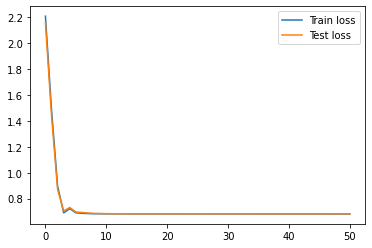

In [121]:
import matplotlib.pyplot as plt
plt.plot(trainL,label="Train loss")
plt.plot(valL,label="Test loss")
plt.legend()
plt.show()

The predict method invokes `fair_metrics`

In [122]:
(
    ACC,
    AUCROC,
    F1,
    ACC_sens0,
    AUCROC_sens0,
    F1_sens0,
    ACC_sens1,
    AUCROC_sens1,
    F1_sens1,
    SP,
    EO,
) = model.predict()

print("ACC:", ACC)
print("AUCROC: ", AUCROC)
print("F1: ", F1)
print("ACC_sens0:", ACC_sens0)
print("AUCROC_sens0: ", AUCROC_sens0)
print("F1_sens0: ", F1_sens0)
print("ACC_sens1: ", ACC_sens1)
print("AUCROC_sens1: ", AUCROC_sens1)
print("F1_sens1: ", F1_sens1)
print("SP: ", SP)
print("EO:", EO)


ACC: 0.5485232067510548
AUCROC:  0.5
F1:  0.5485232067510548
ACC_sens0: 0.581081081081081
AUCROC_sens0:  0.5
F1_sens0:  0.581081081081081
ACC_sens1:  0.5337423312883436
AUCROC_sens1:  0.5
F1_sens1:  0.5337423312883436
SP:  0.0
EO: 0.0


F1 Score, Acc Score. Group-based scores are denoted by METRIC_sens0/1. SP and EO are parity and equal odds 